# Proyecto 2 - Limpieza de imágenes

- Sebastian Aristondo 20880  
- Diego Franco 20240  
- Manuel Archila 161250  
- Juan Diego Avila 20090  
- Daniel Gonzalez Carrillo 20293  

In [4]:
import pandas as pd
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import ndimage

In [5]:
data = pd.read_csv('meta_train_with_vertebrae.csv', encoding='utf-8')

In [6]:
data.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceRatio,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.003731,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.007463,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.011194,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407,0.014925,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782,0.018657,0,0,0,0,0,0,0


In [7]:
def extract_number(filename):
    # Extraer el número de la cadena (por ejemplo, "10" de "10.dcm")
    return int(filename.split('.')[0])

In [8]:
def read_images(path):
    # Obtener la lista de nombres de archivos de imágenes
    image_files = os.listdir(path)
    image_files.sort(key=extract_number)  # Asegura un orden adecuado
    
    # Inicializar una lista para almacenar los volúmenes 3D
    volumes = []

    # Leer y apilar las imágenes en un volumen 3D
    for image_file in image_files:
        image_path = os.path.join(path, image_file)
        dicom_data = pydicom.dcmread(image_path)
        image = apply_voi_lut(dicom_data.pixel_array, dicom_data)
        volumes.append(image)

    # Convertir la lista de volúmenes a un arreglo NumPy 3D
    volumes_array = np.stack(volumes, axis=-1)

    # Normalizar los valores de píxeles en el rango [0, 1]
    # Esto puede variar dependiendo de la información específica de las imágenes DICOM
    volumes_array = (volumes_array - np.min(volumes_array)) / (np.max(volumes_array) - np.min(volumes_array))
    return volumes_array

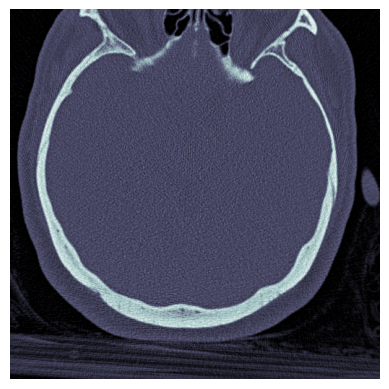

In [9]:
image_path = "train_images/1.2.826.0.1.3680043.27/30.dcm"
dicom_data = pydicom.dcmread(image_path)
# Obtener los píxeles de la imagen
image_pixels = dicom_data.pixel_array

# Mostrar la imagen
plt.imshow(image_pixels, cmap=plt.cm.bone)
plt.axis('off')  # Ocultar ejes
plt.show()

In [10]:
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [11]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 300
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [12]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_images(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [13]:
# # CHUNK TEMPORAL
# data_dir = 'train_images/1.2.826.0.1.3680043.27/'
# volume = process_scan(data_dir)
# output_file = "volumen3D.npy"
# np.save(output_file, volume)

In [14]:
# root = "train_images"
# save_dir = "volumes"
# patients = os.listdir(root)
# count = 0
# for patient in patients:
#     patient_dir = os.path.join(root, patient)
#     volumes = process_scan(patient_dir)
#     output_file = "volumes/" + patient + ".npy"
#     np.save(output_file, volumes)
#     if count >= 10:
#         break
#     count += 1

In [15]:
# load_v = np.load('volumes/1.2.826.0.1.3680043.10136.npy')

In [16]:
# def update_slice(num):
#     plt.clf()  # Limpiar la figura antes de agregar un nuevo cuadro
#     plt.imshow(load_v[:, :, num], cmap='gray')  # Mostrar una rebanada en la posición 'num'
#     plt.title('CT Scan Slice {}'.format(num))
#     plt.axis('off')

# # Crear la figura
# fig = plt.figure()
# # Crear la animación llamando a la función 'update_slice' para cada cuadro
# ani = animation.FuncAnimation(fig, update_slice, frames=load_v.shape[2], interval=100)

# # Ruta y nombre del archivo GIF
# gif_path = "ct_scan_animation.gif"

# # Guardar la animación como un archivo GIF
# ani.save(gif_path, writer='imagemagick')

# print("Animación guardada como", gif_path)

In [24]:
path = 'train_images'
image_files = os.listdir(path)

df = pd.read_csv('train.csv', encoding='utf-8')

condicion = df["StudyInstanceUID"].isin(image_files)

df_filta = df[condicion]

df_filta.to_csv('train_filtrado.csv', index=False)

(1760, 9)